# Predicting NYC Taxi Fares with RAPIDS

RAPIDS is a suite of GPU accelerated data science libraries with APIs that should be familiar to users of Pandas, Dask, and Scikitlearn.

This notebook focuses on showing how to use cuDF with Dask & XGBoost to scale GPU DataFrame ETL-style operations & model training out to multiple GPUs on mutliple nodes as part of Google Cloud Dataproc.

Anaconda has graciously made some of the NYC Taxi dataset available in a public Google Cloud Storage bucket. We'll use our Dataproc Cluster of GPUs to process it and train a model that predicts the fare amount.

For EDA we show the examples using [Holoviews](http://holoviews.org/) and [hvplot](https://hvplot.holoviz.org/). Best way to install Holoviews is to from `conda-forge` channel `conda install -c conda-forge holoviews`
and for hvplot `pyviz` channel. `conda install -c pyviz hvplot`

In [77]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt
import socket, time
import modin.pandas as modin_pd
import xgboost as xgb

#To install Holoviews and hvplot
#conda install -c conda-forge holoviews
#conda install -c pyviz hvplot
# import holoviews as hv
# from holoviews import opts
import numpy as np
# import hvplot.pandas
# import hvplot.dask
# hv.extension('bokeh')

# Inspecting the Data

Now that we have a cluster of GPU workers, we'll use [dask-cudf](https://github.com/rapidsai/dask-cudf/) to load and parse a bunch of CSV files into a distributed DataFrame. 

In [78]:
'''if you get 'ModuleNotFoundError: No module named 'gcsfs', run `!pip install gcsfs` 
'''
base_path = '/localdisk/benchmark_datasets/yellow-taxi-dataset/'

#df_2014 = modin_pd.concat([
#    modin_pd.read_csv(x, parse_dates=[' pickup_datetime', ' dropoff_datetime'])
#    for x in glob.glob(base_path+'2014/yellow_*.csv')])
df_2014 = modin_pd.read_csv(base_path+'2014/yellow_tripdata_2014-01.csv', parse_dates=[' pickup_datetime', ' dropoff_datetime'])
df_2014.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,CMT,2014-01-09 20:45:25,2014-01-09 20:52:31,1,0.7,-73.994770,40.736828,1,N,-73.982227,40.731790,CRD,6.5,0.5,0.5,1.40,0.0,8.90
1,CMT,2014-01-09 20:46:12,2014-01-09 20:55:12,1,1.4,-73.982392,40.773382,1,N,-73.960449,40.763995,CRD,8.5,0.5,0.5,1.90,0.0,11.40
2,CMT,2014-01-09 20:44:47,2014-01-09 20:59:46,2,2.3,-73.988570,40.739406,1,N,-73.986626,40.765217,CRD,11.5,0.5,0.5,1.50,0.0,14.00
3,CMT,2014-01-09 20:44:57,2014-01-09 20:51:40,1,1.7,-73.960213,40.770464,1,N,-73.979863,40.777050,CRD,7.5,0.5,0.5,1.70,0.0,10.20
4,CMT,2014-01-09 20:47:09,2014-01-09 20:53:32,1,0.9,-73.995371,40.717248,1,N,-73.984367,40.720524,CRD,6.0,0.5,0.5,1.75,0.0,8.75


# Data Cleanup

As usual, the data needs to be massaged a bit before we can start adding features that are useful to an ML model.

For example, in the 2014 taxi CSV files, there are `pickup_datetime` and `dropoff_datetime` columns. The 2015 CSVs have `tpep_pickup_datetime` and `tpep_dropoff_datetime`, which are the same columns. One year has `rate_code`, and another `RateCodeID`.

Also, some CSV files have column names with extraneous spaces in them.

Worst of all, starting in the July 2016 CSVs, pickup & dropoff latitude and longitude data were replaced by location IDs, making the second half of the year useless to us.

We'll do a little string manipulation, column renaming, and concatenating of DataFrames to sidestep the problems.

In [79]:
#Dictionary of required columns and their datatypes
must_haves = {
     'pickup_datetime': 'datetime64[s]',
     'dropoff_datetime': 'datetime64[s]',
     'passenger_count': 'int32',
     'trip_distance': 'float32',
     'pickup_longitude': 'float32',
     'pickup_latitude': 'float32',
     'rate_code': 'int32',
     'dropoff_longitude': 'float32',
     'dropoff_latitude': 'float32',
     'fare_amount': 'float32'
    }

In [80]:
def clean(ddf, must_haves):
    # replace the extraneous spaces in column names and lower the font type
    tmp = {col:col.strip().lower() for col in list(ddf.columns)}
    ddf = ddf.rename(columns=tmp)

    ddf = ddf.rename(columns={
        'tpep_pickup_datetime': 'pickup_datetime',
        'tpep_dropoff_datetime': 'dropoff_datetime',
        'ratecodeid': 'rate_code'
    })
    
#    ddf['pickup_datetime'] = ddf['pickup_datetime'].astype('datetime64[ms]')
#    ddf['dropoff_datetime'] = ddf['dropoff_datetime'].astype('datetime64[ms]')

    for col in ddf.columns:
        if col not in must_haves:
            ddf = ddf.drop(columns=col)
            continue
        # if column was read as a string, recast as float
        if ddf[col].dtype == 'object':
            ddf[col] = ddf[col].fillna('-1')
#            ddf[col] = ddf[col].astype('float32')
#        else:
            # downcast from 64bit to 32bit types
            # Tesla T4 are faster on 32bit ops
#            if 'int' in str(ddf[col].dtype):
#                ddf[col] = ddf[col].astype('int32')
#            if 'float' in str(ddf[col].dtype):
#                ddf[col] = ddf[col].astype('float32')
#            ddf[col] = ddf[col].fillna(-1)
    
    return ddf

<b> NOTE: </b>We will realize that some of 2015 data has column name as `RateCodeID` and others have `RatecodeID`. When we rename the columns in the clean function, it internally doesn't pass meta while calling map_partitions(). This leads to the error of column name mismatch in the returned data. For this reason, we will call the clean function with map_partition and pass the meta to it. Here is the link to the bug created for that: https://github.com/rapidsai/cudf/issues/5413 

In [81]:
df_2014 = clean(df_2014, must_haves)

We still have 2015 and the first half of 2016's data to read and clean. Let's increase our dataset.

In [82]:
#df_2015 = modin_pd.concat([
#    clean(modin_pd.read_csv(x, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime']), must_haves)
#    for x in glob.glob(base_path + '2015/yellow_*.csv')])
df_2015 = modin_pd.read_csv(base_path + '2015/yellow_tripdata_2015-01.csv', parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

In [83]:
# clean on whole dataframe is not needed because clean is applied inside of concat loop to
# unify "RateCodeID" and "RatecodeID" in different months.
df_2015 = clean(df_2015, must_haves)

# Handling 2016's Mid-Year Schema Change

In 2016, only January - June CSVs have the columns we need. If we try to read base_path+2016/yellow_*.csv, Dask will not appreciate having differing schemas in the same DataFrame.

Instead, we'll need to create a list of the valid months and read them independently.

In [84]:
months = [str(x).rjust(2, '0') for x in range(1, 7)]
valid_files = [base_path+'2016/yellow_tripdata_2016-'+month+'.csv' for month in months]

In [85]:
#read & clean 2016 data and concat all DFs
#df_2016 = modin_pd.concat([
#    clean(modin_pd.read_csv(x, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime']), must_haves)
#    for x in valid_files])
df_2016 = clean(modin_pd.read_csv(valid_files[0], parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime']), must_haves)

In [86]:
#concatenate multiple DataFrames into one bigger one
taxi_df = modin_pd.concat([df_2014, df_2015, df_2016])

In [87]:
# taxi_df = taxi_df.persist()
taxi_df.dtypes

pickup_datetime      datetime64[ns]
dropoff_datetime     datetime64[ns]
passenger_count               int64
trip_distance               float64
pickup_longitude            float64
pickup_latitude             float64
rate_code                     int64
dropoff_longitude           float64
dropoff_latitude            float64
fare_amount                 float64
dtype: object

In [88]:
len(taxi_df)

37438336

## Exploratory Data Analysis (EDA)

Here, we are checking out if there are any non-sensical records and outliers, and in such case, we need to remove them from the dataset.

In [89]:
# check out if there is any negative total trip time
taxi_df[taxi_df.dropoff_datetime <= taxi_df.pickup_datetime].head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount
3832,2014-01-09 20:27:41,2014-01-09 19:05:21,1,1.8,0.000000,0.000000,1,-73.969591,40.789003,9.5
16134,2014-01-09 22:15:40,2014-01-09 22:15:14,1,1.3,0.000000,0.000000,1,-74.002861,40.760625,7.5
16181,2014-01-09 22:27:13,2014-01-09 22:26:49,1,1.9,0.000000,0.000000,1,-73.976287,40.741631,8.5
16873,2014-01-10 00:14:23,2014-01-10 00:14:23,1,0.7,-74.005136,40.718694,1,-74.003879,40.728503,4.0
25248,2014-01-10 00:39:16,2014-01-10 00:38:59,1,1.5,0.000000,0.000000,1,-73.999284,40.733897,6.5


In [90]:
# check out if there is any abnormal data where trip distance is short, but the fare is very high.
taxi_df[(taxi_df.trip_distance < 10) & (taxi_df.fare_amount > 300)].head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount
373953,2014-01-12 15:03:38,2014-01-12 15:05:31,1,0.0,-73.823842,40.690258,5,-73.823847,40.690280,400.0
520658,2014-01-06 23:44:07,2014-01-06 23:45:01,1,0.0,-73.927900,41.677242,5,-73.927900,41.677242,370.0
525419,2014-01-06 23:50:28,2014-01-06 23:51:40,1,0.0,-73.927900,41.677242,5,-73.927900,41.677242,370.0
562916,2014-01-07 12:09:38,2014-01-07 12:10:27,1,0.0,-73.929695,40.812032,5,-73.929695,40.812032,500.0
576409,2014-01-07 16:35:10,2014-01-07 16:35:41,1,0.0,-73.996006,40.720933,5,-73.996007,40.720928,500.0


In [91]:
# check out if there is any abnormal data where trip distance is long, but the fare is very low.
taxi_df[(taxi_df.trip_distance > 50) & (taxi_df.fare_amount < 50)].head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount
11580,2014-01-09 22:22:14,2014-01-09 22:42:59,1,82.1,-74.002175,40.751753,1,-73.964216,40.719554,20.0
33723,2014-01-10 05:43:48,2014-01-10 06:12:20,1,84.2,-73.965053,40.806673,1,-73.957981,40.713139,34.5
122880,2014-01-10 18:16:53,2014-01-10 18:48:53,1,89.9,-73.997185,40.742357,1,-73.948361,40.779271,21.5
226264,2014-01-11 13:22:07,2014-01-11 13:40:16,1,81.7,-73.991685,40.759871,1,-73.994985,40.726054,13.5
290203,2014-01-11 20:12:50,2014-01-11 20:15:15,1,60.4,-73.968109,40.770878,1,-73.972598,40.764607,4.0


In [92]:
#Using only 2016-01 data for visuals.
#taxi_df_cdf = clean(cudf.read_csv(valid_files[0]),must_haves)

#Using entire 2016 data for visualization
taxi_df_cdf = taxi_df

In [93]:
taxi_df

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount
0,2014-01-09 20:45:25,2014-01-09 20:52:31,1,0.7,-73.994770,40.736828,1,-73.982227,40.731790,6.5
1,2014-01-09 20:46:12,2014-01-09 20:55:12,1,1.4,-73.982392,40.773382,1,-73.960449,40.763995,8.5
2,2014-01-09 20:44:47,2014-01-09 20:59:46,2,2.3,-73.988570,40.739406,1,-73.986626,40.765217,11.5
3,2014-01-09 20:44:57,2014-01-09 20:51:40,1,1.7,-73.960213,40.770464,1,-73.979863,40.777050,7.5
4,2014-01-09 20:47:09,2014-01-09 20:53:32,1,0.9,-73.995371,40.717248,1,-73.984367,40.720524,6.0
...,...,...,...,...,...,...,...,...,...,...
10906853,2016-01-31 23:30:32,2016-01-31 23:38:18,1,2.2,-74.003578,40.751011,1,-73.982651,40.767509,8.5
10906854,2016-01-05 00:15:55,2016-01-05 00:16:06,1,0.0,-73.945488,40.751530,1,-73.945457,40.751530,2.5
10906855,2016-01-05 06:12:46,2016-03-19 20:45:50,3,1.4,-73.994240,40.766586,1,-73.984428,40.753922,7.5
10906856,2016-01-05 06:21:44,2016-03-28 12:54:26,1,2.1,-73.948067,40.776531,1,-73.978188,40.777435,11.5


In [94]:
# apply a list of filter conditions to throw out records with missing or outlier values
query_frags = [
    'fare_amount > 1 and fare_amount < 500',
    'passenger_count > 0 and passenger_count < 6',
    'pickup_longitude > -75 and pickup_longitude < -73',
    'dropoff_longitude > -75 and dropoff_longitude < -73',
    'pickup_latitude > 40 and pickup_latitude < 42',
    'dropoff_latitude > 40 and dropoff_latitude < 42',
    'trip_distance > 0 and trip_distance < 500',
    'not (trip_distance > 50 and fare_amount < 50)',
    'not (trip_distance < 10 and fare_amount > 300)',
    'not dropoff_datetime <= pickup_datetime'
]
taxi_df = taxi_df.query(' and '.join(query_frags))

In [95]:
# reset_index and drop index column
taxi_df = taxi_df.reset_index(drop=True)
taxi_df

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount
0,2014-01-09 20:45:25,2014-01-09 20:52:31,1,0.70,-73.994770,40.736828,1,-73.982227,40.731790,6.5
1,2014-01-09 20:46:12,2014-01-09 20:55:12,1,1.40,-73.982392,40.773382,1,-73.960449,40.763995,8.5
2,2014-01-09 20:44:47,2014-01-09 20:59:46,2,2.30,-73.988570,40.739406,1,-73.986626,40.765217,11.5
3,2014-01-09 20:44:57,2014-01-09 20:51:40,1,1.70,-73.960213,40.770464,1,-73.979863,40.777050,7.5
4,2014-01-09 20:47:09,2014-01-09 20:53:32,1,0.90,-73.995371,40.717248,1,-73.984367,40.720524,6.0
...,...,...,...,...,...,...,...,...,...,...
35266606,2016-01-31 22:53:00,2016-01-31 22:59:37,1,1.68,-74.003578,40.750751,1,-74.002159,40.734909,7.0
35266607,2016-01-31 23:00:11,2016-01-31 23:12:08,1,2.65,-74.002159,40.734852,1,-73.999680,40.761669,11.0
35266608,2016-01-31 23:30:32,2016-01-31 23:38:18,1,2.20,-74.003578,40.751011,1,-73.982651,40.767509,8.5
35266609,2016-01-05 06:12:46,2016-03-19 20:45:50,3,1.40,-73.994240,40.766586,1,-73.984428,40.753922,7.5


# Adding Interesting Features

Dask & cuDF provide standard DataFrame operations, but also let you run "user defined functions" on the underlying data. Here we use [dask.dataframe's map_partitions](https://docs.dask.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.map_partitions) to apply user defined python function on each DataFrame partition.

We'll use a Haversine Distance calculation to find total trip distance, and extract additional useful variables from the datetime fields.

In [96]:
## add features

taxi_df['hour'] = taxi_df['pickup_datetime'].dt.hour
taxi_df['year'] = taxi_df['pickup_datetime'].dt.year
taxi_df['month'] = taxi_df['pickup_datetime'].dt.month
taxi_df['day'] = taxi_df['pickup_datetime'].dt.day
taxi_df['day_of_week'] = taxi_df['pickup_datetime'].dt.weekday
taxi_df['is_weekend'] = (taxi_df['day_of_week']>=5).astype('int32')

#calculate the time difference between dropoff and pickup.
taxi_df['diff'] = taxi_df['dropoff_datetime'].astype('int64') - taxi_df['pickup_datetime'].astype('int64')
taxi_df['diff']=(taxi_df['diff']/1000).astype('int64')

taxi_df['pickup_latitude_r'] = taxi_df['pickup_latitude']//.01*.01
taxi_df['pickup_longitude_r'] = taxi_df['pickup_longitude']//.01*.01
taxi_df['dropoff_latitude_r'] = taxi_df['dropoff_latitude']//.01*.01
taxi_df['dropoff_longitude_r'] = taxi_df['dropoff_longitude']//.01*.01

taxi_df = taxi_df.drop('pickup_datetime', axis=1)
taxi_df = taxi_df.drop('dropoff_datetime', axis=1)

In [97]:
import numpy as np

geo_columns = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
radians = {x: np.radians(taxi_df[x]) for x in geo_columns}
dlon = radians['pickup_longitude'] - radians['dropoff_longitude']
dlat = radians['pickup_latitude'] - radians['dropoff_latitude']

taxi_df['h_distance'] = 6367 * 2 * np.arcsin(
    np.sqrt(
        np.sin(dlat / 2)**2
        + np.cos(radians['pickup_latitude']) * np.cos(radians['dropoff_latitude']) * np.sin(dlon / 2)**2))

In [98]:
taxi_df

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount,hour,year,month,day,day_of_week,is_weekend,diff,pickup_latitude_r,pickup_longitude_r,dropoff_latitude_r,dropoff_longitude_r,h_distance
0,1,0.70,-73.994770,40.736828,1,-73.982227,40.731790,6.5,20,2014,1,9,3,0,426000000,40.73,-74.00,40.73,-73.99,1.195381
1,1,1.40,-73.982392,40.773382,1,-73.960449,40.763995,8.5,20,2014,1,9,3,0,540000000,40.77,-73.99,40.76,-73.97,2.120985
2,2,2.30,-73.988570,40.739406,1,-73.986626,40.765217,11.5,20,2014,1,9,3,0,899000000,40.73,-73.99,40.76,-73.99,2.872915
3,1,1.70,-73.960213,40.770464,1,-73.979863,40.777050,7.5,20,2014,1,9,3,0,403000000,40.77,-73.97,40.77,-73.98,1.808353
4,1,0.90,-73.995371,40.717248,1,-73.984367,40.720524,6.0,20,2014,1,9,3,0,383000000,40.71,-74.00,40.72,-73.99,0.995734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35266606,1,1.68,-74.003578,40.750751,1,-74.002159,40.734909,7.0,22,2016,1,31,6,1,397000000,40.75,-74.01,40.73,-74.01,1.764542
35266607,1,2.65,-74.002159,40.734852,1,-73.999680,40.761669,11.0,23,2016,1,31,6,1,717000000,40.73,-74.01,40.76,-74.00,2.987380
35266608,1,2.20,-74.003578,40.751011,1,-73.982651,40.767509,8.5,23,2016,1,31,6,1,466000000,40.75,-74.01,40.76,-73.99,2.542504
35266609,3,1.40,-73.994240,40.766586,1,-73.984428,40.753922,7.5,6,2016,1,5,1,0,6445984000000,40.76,-74.00,40.75,-73.99,1.631785


# Cluster trips by pick up and drop off coordinates

In [99]:
# Use only columns with coordinates
training_df = taxi_df[["dropoff_latitude", "dropoff_longitude", "pickup_latitude", "pickup_longitude"]]

xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]
# Use only trips with coordinates in window `xlim`-`ylim`
training_df = training_df[(training_df["pickup_longitude"] > xlim[0]) & (training_df["pickup_longitude"] < xlim[1])]
training_df = training_df[(training_df["dropoff_longitude"] > xlim[0]) & (training_df["dropoff_longitude"] < xlim[1])]
training_df = training_df[(training_df["pickup_latitude"] > ylim[0]) & (training_df["pickup_latitude"] < ylim[1])]
training_df = training_df[(training_df["dropoff_latitude"] > ylim[0]) & (training_df["dropoff_latitude"] < ylim[1])]

In [100]:
# Combine latitude/longitude of pick up and drop off points
latitude = list(training_df.pickup_latitude) + list(training_df.dropoff_latitude)
longitude = list(training_df.pickup_longitude) + list(training_df.dropoff_longitude)
location_df = modin_pd.DataFrame({"longitude": longitude, "latitude": latitude})


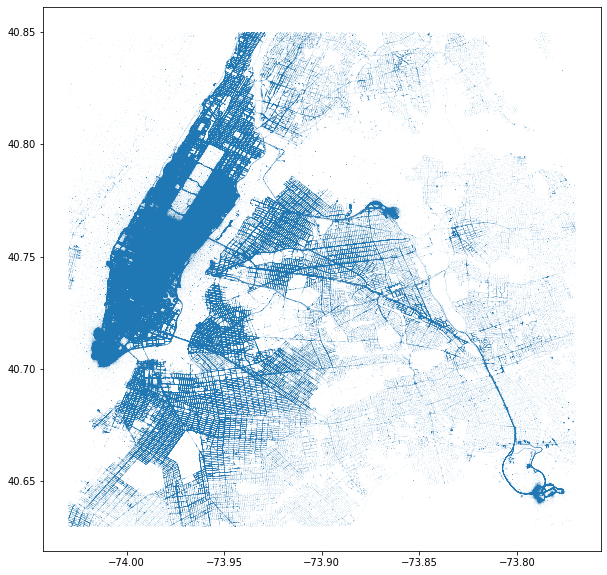

In [101]:
# Draw all points of pickup/dropoff
plt.figure(figsize = (10,10))
plt.plot(longitude,latitude,'.', alpha = 0.4, markersize = 0.05)
plt.show()

In [102]:
import sklearn as skl
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [103]:
kmeans = skl.cluster.KMeans(n_clusters=15, random_state=2, n_init=10)
fit_result = kmeans.fit(location_df)
location_df['label'] = kmeans.labels_

In [104]:
# Get sample points
sample_df = location_df.sample(200000)


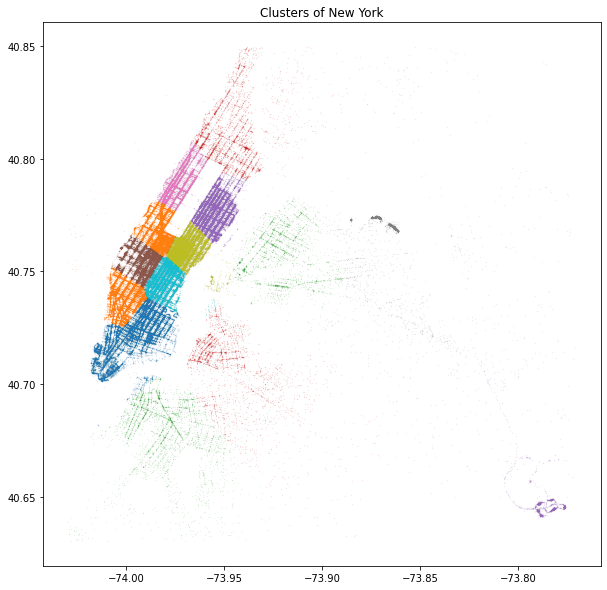

In [105]:
plt.figure(figsize = (10,10))
for label in sample_df.label.unique():
    plt.plot(sample_df.longitude[sample_df.label == label],sample_df.latitude[sample_df.label == label],'.', alpha = 0.3, markersize = 0.3)

plt.title('Clusters of New York')
plt.show()

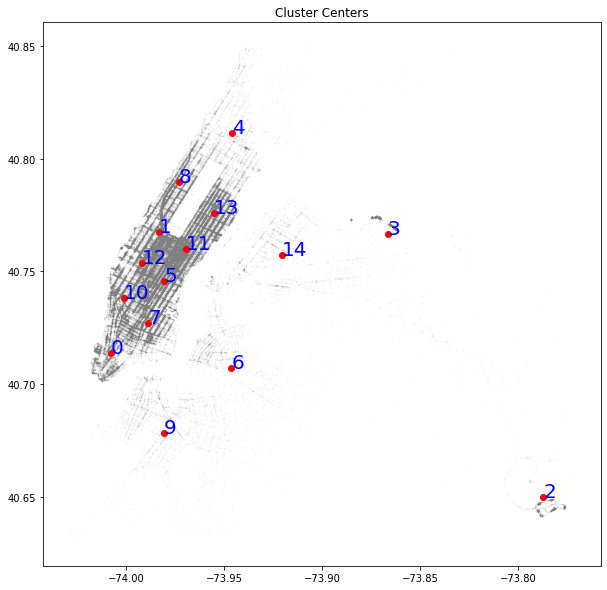

In [106]:
fig,ax = plt.subplots(figsize = (10,10))
for label in sample_df.label.unique():
    ax.plot(sample_df.longitude[sample_df.label == label],sample_df.latitude[sample_df.label == label],'.', alpha = 0.4, markersize = 0.1, color = 'gray')
    ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')
    ax.annotate(label, (kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1]), color = 'b', fontsize = 20)
ax.set_title('Cluster Centers')
plt.show()